In [1]:
# Imports
import os
os.chdir("/projectnb/labci/Lucia/edu-bayesian-MCMC/")

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pymc as pm
from pymc import PolyaGamma as PG
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

from src.samplers.MetropolisGibbs import gibbs
from src.samplers.PolyaGamma import polyagamma

torch.manual_seed(42)

In [16]:
# Simulate data
I = 10   # exam items
P = 100  # pupils

init_a = torch.zeros(I)  
init_b = torch.zeros(I)  
init_t = torch.zeros(P)  
init_W = torch.zeros(P, I)


true_a = torch.empty(size=(I,))      # items' discriminatory power
true_b = torch.empty(size=(I,))      # items' difficulty
true_theta = torch.empty(size=(P,))  # students' skills
true_W = torch.empty(size=(P,I))     # latent variable (for PG case)
Y = torch.empty(size=(P, I))         # simulated data

# populate a, b:
for i in range(I):
    U = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
    true_a[i] = U.sample()
    true_b[i] = -1.0*U.sample()
    
# populate theta:
for p in range(P):
    U = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
    true_theta[p] = U.sample()

# populate W:
scales = torch.mul(torch.t(true_a[:, None]), true_theta[:, None]) + true_b
true_W = torch.from_numpy(pm.draw(PG.dist(h=1, z=scales)))

# generate exam data:
for i in range(I):
    for p in range(P):
        prob = torch.exp(true_a[i]*true_theta[p] + true_b[i]) / (1 + torch.exp(true_a[i]*true_theta[p] + true_b[i]))
        B = torch.distributions.Bernoulli(prob)
        Y[p][i] = B.sample()

In [26]:
# Run samplers
N = 10000
sigmasq_a, sigmasq_b, sigmasq_t = torch.tensor([0.5]), torch.tensor([0.5]), torch.tensor([0.5])  # priors

samples_mwg = gibbs(init_a, init_b, init_t, Y, sigmasq_a, sigmasq_b, sigmasq_t, niter=N, adapt=False)
samples_ada_mwg = gibbs(init_a, init_b, init_t, Y, sigmasq_a, sigmasq_b, sigmasq_t, niter=N, adapt=True)
samples_pg = polyagamma(init_a, init_b, init_t, init_W, Y, sigmasq_a, sigmasq_b, sigmasq_t, niter=N)

Starting Gibbs sampler... 
--------------------------------------------



100%|██████████| 4999/4999 [11:39<00:00,  7.14it/s]


Done sampling.
Average acceptance rates:
 tensor([0.3274, 0.4353, 0.3116, 0.2072, 0.1821, 0.2750, 0.4633, 0.2400, 0.2896,
        0.4615]) 
 tensor([0.2121, 0.3038, 0.1736, 0.0961, 0.0870, 0.1444, 0.3821, 0.1132, 0.1563,
        0.3763]) 
 tensor([0.5229, 0.5693, 0.5312, 0.5882, 0.5782, 0.5905, 0.5857, 0.5702, 0.5258,
        0.4881, 0.5841, 0.5948, 0.5266, 0.5812, 0.5343, 0.5549, 0.5973, 0.5804,
        0.5571, 0.5389, 0.5659, 0.5736, 0.5647, 0.5550, 0.5920, 0.5941, 0.5743,
        0.5831, 0.5675, 0.5482, 0.5402, 0.5476, 0.5768, 0.5904, 0.5903, 0.5926,
        0.5919, 0.5900, 0.5817, 0.5494, 0.5749, 0.5869, 0.5857, 0.5929, 0.5807,
        0.5613, 0.5494, 0.5359, 0.4909, 0.5968, 0.5600, 0.5796, 0.5822, 0.5403,
        0.5625, 0.5928, 0.5676, 0.5231, 0.5947, 0.5940, 0.5907, 0.5451, 0.5832,
        0.5788, 0.5378, 0.5807, 0.5554, 0.5213, 0.5209, 0.6004, 0.5751, 0.5645,
        0.5397, 0.5858, 0.5042, 0.5447, 0.5498, 0.5677, 0.5868, 0.5969, 0.5668,
        0.5780, 0.5784, 0.5311, 0.5649, 

100%|██████████| 4999/4999 [10:11<00:00,  8.18it/s]


Done sampling.
Average acceptance rates:
 tensor([0.3012, 0.3008, 0.3007, 0.2984, 0.2994, 0.3008, 0.2991, 0.3020, 0.2961,
        0.3028]) 
 tensor([0.3033, 0.3008, 0.3002, 0.2947, 0.2986, 0.2957, 0.3008, 0.2977, 0.3021,
        0.3010]) 
 tensor([0.3005, 0.3001, 0.2990, 0.3008, 0.2981, 0.3004, 0.2996, 0.2999, 0.2980,
        0.2985, 0.3015, 0.3017, 0.2995, 0.3006, 0.2974, 0.2997, 0.3002, 0.3021,
        0.3020, 0.2962, 0.2981, 0.2996, 0.3000, 0.2996, 0.2979, 0.2997, 0.3010,
        0.3005, 0.3024, 0.3018, 0.3018, 0.3005, 0.2999, 0.3018, 0.2992, 0.3025,
        0.3000, 0.3042, 0.3014, 0.3031, 0.3007, 0.2994, 0.2991, 0.2989, 0.3006,
        0.2972, 0.3018, 0.2991, 0.2989, 0.2997, 0.3027, 0.3042, 0.3034, 0.3006,
        0.3012, 0.3017, 0.3008, 0.3029, 0.3029, 0.2988, 0.2984, 0.3025, 0.3030,
        0.2986, 0.2999, 0.3026, 0.3027, 0.3007, 0.3010, 0.2993, 0.2998, 0.2981,
        0.2994, 0.2999, 0.3011, 0.2970, 0.2974, 0.3014, 0.2997, 0.2993, 0.3013,
        0.3053, 0.3026, 0.2984, 0.3017, 

100%|██████████| 4999/4999 [02:25<00:00, 34.47it/s]


### Traceplots

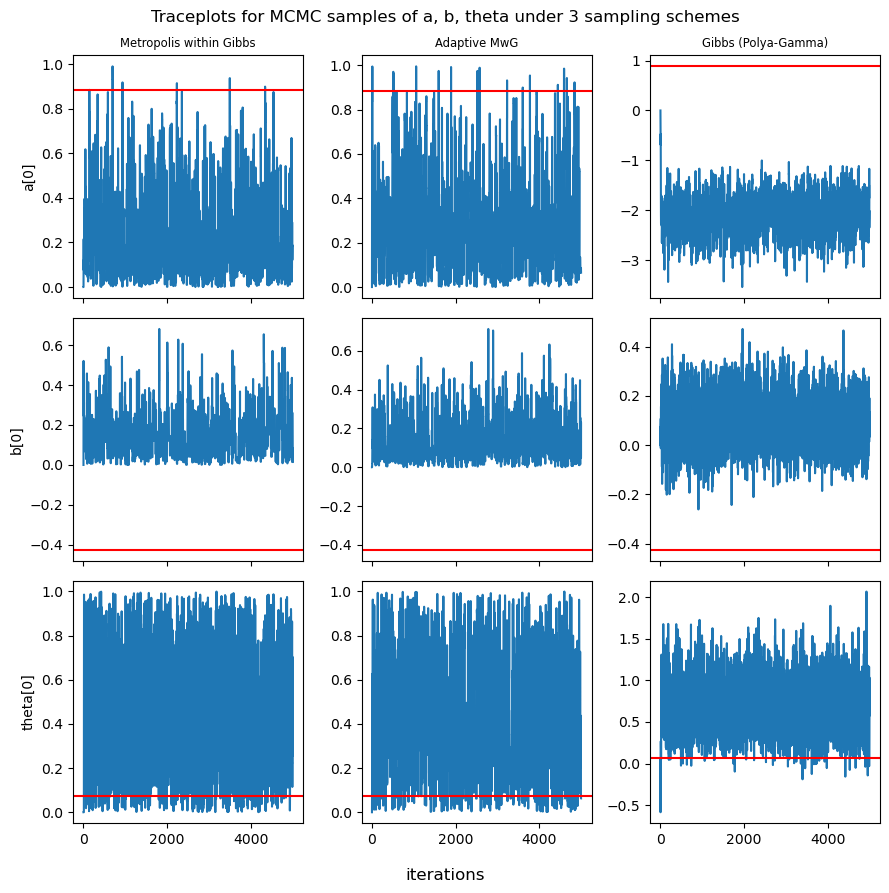

In [75]:
fig1, axs = plt.subplots(nrows=3, ncols=3, figsize=(9,9), sharex=True)
fig1.suptitle("Traceplots for MCMC samples of a, b, theta under 3 sampling schemes")

t = range(N)
data_to_plot = [samples_mwg[0][:,0], samples_ada_mwg[0][:,0], samples_pg[0][:,0],
                samples_mwg[1][:,0], samples_ada_mwg[1][:,0], samples_pg[1][:,0],
                samples_mwg[2][:,0], samples_ada_mwg[2][:,0], samples_pg[2][:,0]]

true_values = [true_a[0], true_a[0], true_a[0],
               true_b[0], true_b[0], true_b[0],
               true_theta[0], true_theta[0], true_theta[0]]

cols = ["Metropolis within Gibbs", "Adaptive MwG", "Gibbs (Polya-Gamma)"]
rows = ["a[0]", "b[0]", "theta[0]"]

for i, ax in enumerate(fig1.axes):
    ax.plot(t, data_to_plot[i])
    ax.axhline(true_values[i], color="red")

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size="small")

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90)

fig1.supxlabel('iterations')
fig1.tight_layout()
plt.show()

### Histograms

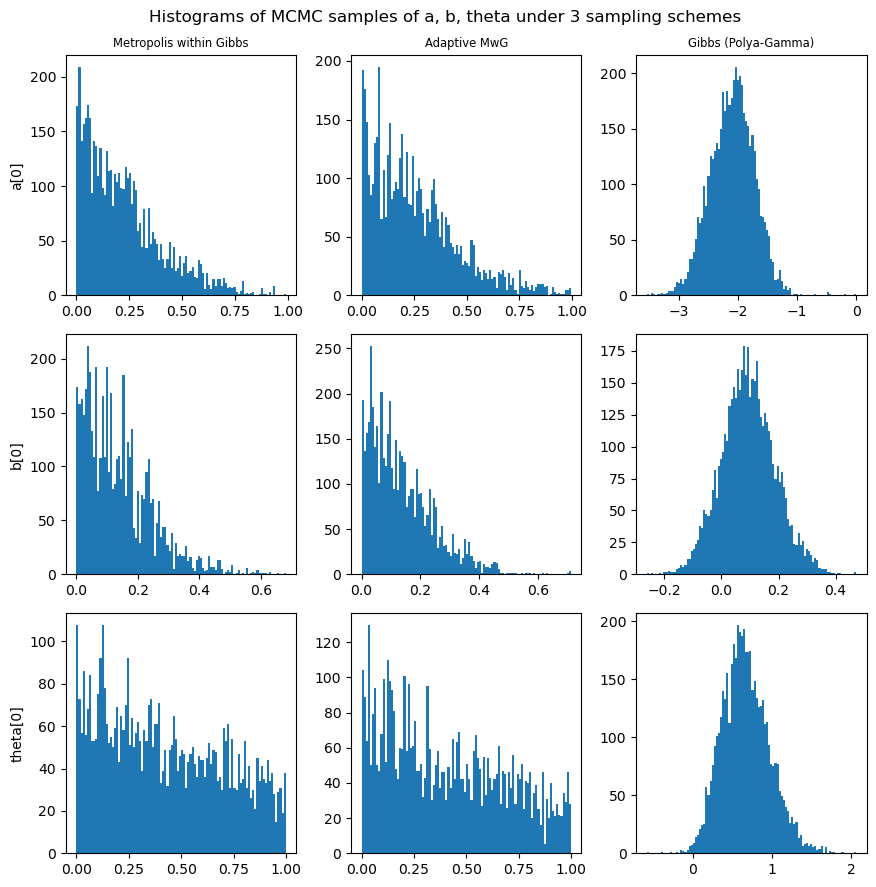

In [74]:
fig2, axs = plt.subplots(nrows=3, ncols=3, figsize=(9,9))
fig2.suptitle("Histograms of MCMC samples of a, b, theta under 3 sampling schemes")

cols = ["Metropolis within Gibbs", "Adaptive MwG", "Gibbs (Polya-Gamma)"]
rows = ["a[0]", "b[0]", "theta[0]"]

for i, ax in enumerate(fig2.axes):
    ax.hist(data_to_plot[i], bins=100)

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size="small")

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90)

fig2.tight_layout()
plt.show()

### Autocorrelation

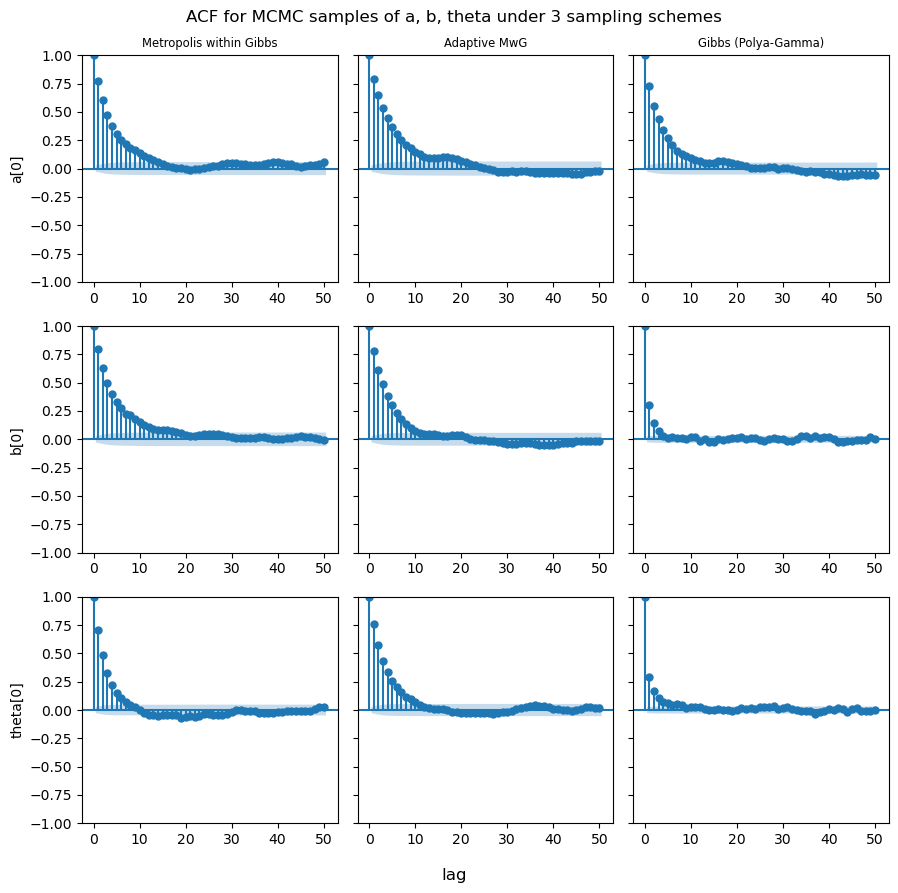

In [73]:
fig3, axs = plt.subplots(nrows=3, ncols=3, figsize=(9,9), sharey=True)
fig3.suptitle("ACF for MCMC samples of a, b, theta under 3 sampling schemes")

cols = ["Metropolis within Gibbs", "Adaptive MwG", "Gibbs (Polya-Gamma)"]
rows = ["a[0]", "b[0]", "theta[0]"]

for i, ax in enumerate(fig3.axes):
    tsaplots.plot_acf(data_to_plot[i], lags=50, ax=ax, title="")

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size="small")

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90)

fig3.supxlabel('lag')
fig3.tight_layout()
plt.show()

### Asymptotic Variance

### Accuracy

In [13]:
MSE = nn.MSELoss()
MSE_a_mwg = MSE(samples_mwg[0], true_a)
MSE_b_mwg = MSE(samples_mwg[1], true_b)
MSE_t_mwg = MSE(samples_mwg[2], true_theta)
print(torch.mean(MSE_a_mwg))
print(torch.mean(MSE_b_mwg))
print(torch.mean(MSE_t_mwg))

MSE_a_ada_mwg = MSE(samples_ada_mwg[0], true_a)
MSE_b_ada_mwg = MSE(samples_ada_mwg[1], true_b)
MSE_t_ada_mwg = MSE(samples_ada_mwg[2], true_theta)
print(torch.mean(MSE_a_ada_mwg))
print(torch.mean(MSE_b_ada_mwg))
print(torch.mean(MSE_t_ada_mwg))

MSE_a_pg = MSE(samples_pg[0], true_a)
MSE_b_pg = MSE(samples_pg[1], true_b)
MSE_t_pg = MSE(samples_pg[2], true_theta)
MSE_w_pg = MSE(samples_pg[3], true_W)
print(torch.mean(MSE_a_pg))
print(torch.mean(MSE_b_pg))
print(torch.mean(MSE_t_pg))
print(torch.mean(MSE_w_pg))

# TODO: how to deal with the broadcasting of MSE? write a custom MSE function? plot error over time and then average?

tensor(0.2686)
tensor(0.2637)
tensor(0.1509)
tensor(0.2672)
tensor(0.2704)
tensor(0.1536)
tensor(1.4330)
tensor(0.0952)
tensor(0.6175)
tensor(0.0804, dtype=torch.float64)


/projectnb/labci/luciav/.conda/envs/edu-mcmc/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/projectnb/labci/luciav/.conda/envs/edu-mcmc/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([100, 1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/projectnb/labci/luciav/.conda/envs/edu-mcmc/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1000, 100])) that is different to the input size (torch.Size([100, 1000, 100])). T